In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

from definitions import PROCESSED_DATA_DIR
from src.data.indicators import rsi, stochRSI, ema
from src.models.strategies import RSIStoch200EMA, BuyAndHold

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
btcusdt = pd.read_csv(PROCESSED_DATA_DIR / 'BTCUSDT.csv')
btcusdt.index = pd.DatetimeIndex(btcusdt['open time'])

btcusdt

open time      open      high       low  \
open time                                                                
2017-08-17 20:30:00  2017-08-17 20:30:00   4301.91   4354.84   4262.53   
2017-08-17 21:00:00  2017-08-17 21:00:00   4346.74   4369.69   4315.85   
2017-08-17 21:30:00  2017-08-17 21:30:00   4349.33   4369.69   4309.23   
2017-08-17 22:00:00  2017-08-17 22:00:00   4333.55   4349.63   4310.00   
2017-08-17 22:30:00  2017-08-17 22:30:00   4326.29   4359.13   4319.11   
...                                  ...       ...       ...       ...   
2021-05-31 21:30:00  2021-05-31 21:30:00  36775.02  37087.30  36623.01   
2021-05-31 22:00:00  2021-05-31 22:00:00  36932.55  37250.00  36863.28   
2021-05-31 22:30:00  2021-05-31 22:30:00  37090.16  37140.00  36835.85   
2021-05-31 23:00:00  2021-05-31 23:00:00  36879.23  37345.00  36800.93   
2021-05-31 23:30:00  2021-05-31 23:30:00  37301.51  37499.00  37231.13   

                        close       volume           ema         rsi  \
open time                                                              
2017-08-17 20:30:00   4346.74    15.184266   4346.740000         NaN   
2017-08-17 21:00:00   4349.33    29.292665   4346.765771  100.000000   
2017-08-17 21:30:00   4333.55    32.480371   4346.634271   13.225186   
2017-08-17 22:00:00   4326.29    26.241174   4346.431840    9.248769   
2017-08-17 22:30:00   4336.80    31.134968   4346.336001   38.211911   
...                       ...          ...           ...         ...   
2021-05-31 21:30:00  36932.55   840.717074  36229.710395   58.482794   
2021-05-31 22:00:00  37090.16  1407.839699  36238.272082   61.498708   
2021-05-31 22:30:00  36879.23   908.355699  36244.649773   55.670255   
2021-05-31 23:00:00  37301.51  1160.566735  36255.165795   63.191393   
2021-05-31 23:30:00  37253.81  1488.587448  36265.102554   61.913553   

                      stoch_k   stoch_d  
open time                                
2017-08-17 20:30:00       NaN       NaN  
2017-08-17 21:00:00       NaN       NaN  
2017-08-17 21:30:00       NaN       NaN  
2017-08-17 22:00:00       NaN       NaN  
2017-08-17 22:30:00       NaN       NaN  
...                       ...       ...  
2021-05-31 21:30:00  0.198487  0.133164  
2021-05-31 22:00:00  0.419132  0.235186  
2021-05-31 22:30:00  0.430699  0.349439  
2021-05-31 23:00:00  0.580911  0.476914  
2021-05-31 23:30:00  0.651560  0.554390  

[66391 rows x 10 columns]

In [21]:
strategy = RSIStoch200EMA(
    max_number_open_trades=3,
    min_period_to_last_low=5,
    max_period_to_last_low=50,
    min_absolute_slope_rsi=0.2,
    swing_low_margin=2
)

results = strategy.apply(
    ohlcv_timeseries=btcusdt.iloc[:1500],
    asset_name='BTCUSDT'
)

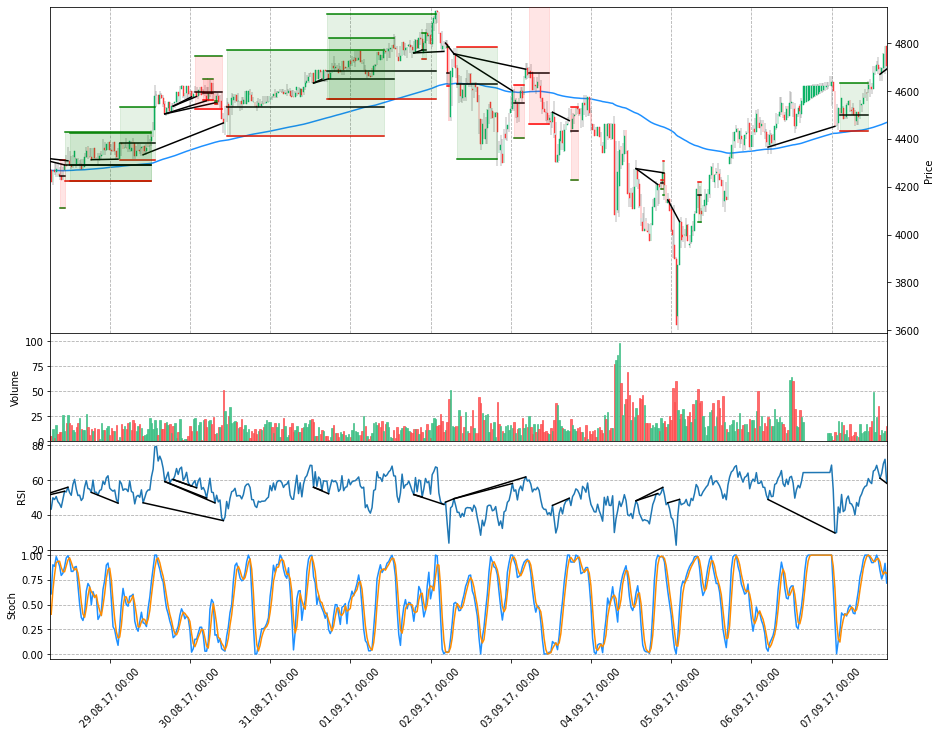

In [22]:
start_time = btcusdt.iloc[500].name
end_time = btcusdt.iloc[1000].name
results.plot(start_time, end_time)

In [7]:
buyandhold_strategy = BuyAndHold()
results = buyandhold_strategy.apply(
    ohlcv_timeseries=btcusdt,
    asset_name='BTCUSDT'
)
results.evaluation()
results.pnl

7.570517215200358

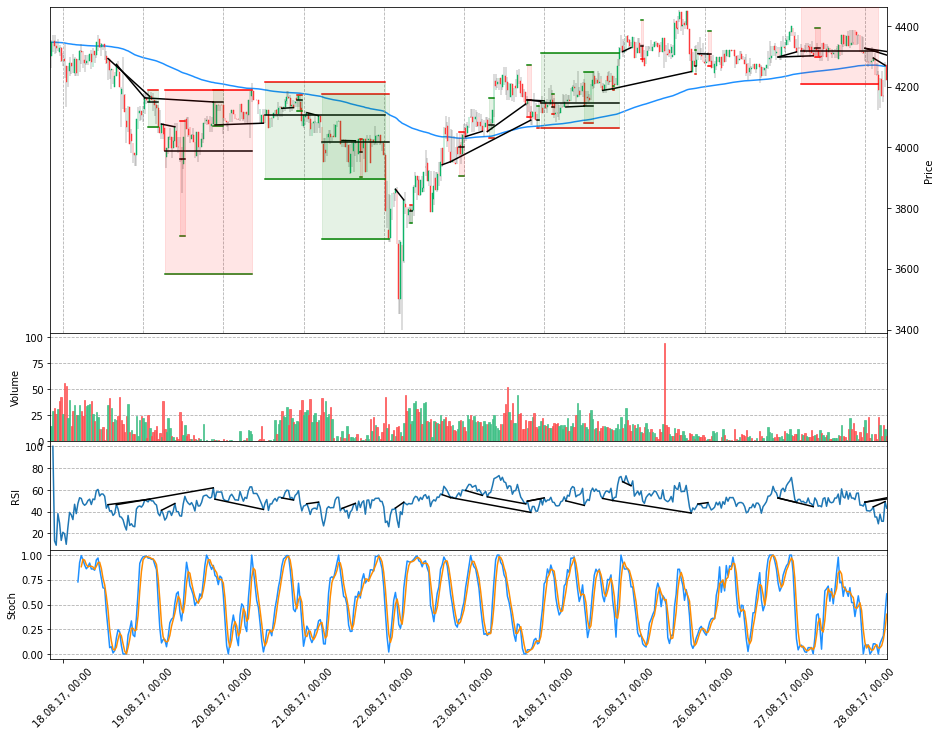

In [123]:
strategy = RSIStoch200EMA(
    max_number_open_trades=3,
    min_period_to_last_low=5,
    max_period_to_last_low=50,
    min_absolute_slope_rsi=0.2,
    swing_low_margin=2
)

results = strategy.apply(
    ohlcv_timeseries=btcusdt.iloc[:1000],
    asset_name='BTCUSDT'
)

#start_time = btcusdt.iloc[200].name
#end_time = btcusdt.iloc[400].name
results.plot(btcusdt.iloc[0].name, btcusdt.iloc[500].name)

In [124]:
import numpy as np

max_number_open_trades=3

total = 1.0
num_positions = 0

# Convert trades to chronology of buy/sell events
events = []
for t in results.trades:
    # Calculate profit and loss of individual trade
    if t['win']:
        if t['entry_price'] > t['take_profit']:  # short trade
            pnl = - (t['take_profit'] / t['entry_price'] - 1.0)
        else:  # long trade
            pnl = t['take_profit'] / t['entry_price'] - 1.0
    else:
        if t['entry_price'] < t['stop_loss']:  # short trade
            pnl = - (t['stop_loss'] / t['entry_price'] - 1.0)
        else:  # long trade
            pnl = t['stop_loss'] / t['entry_price'] - 1.0
    events.append({
        'timestamp': t['entry_time'],
        'event': 'entry',
        'entry_time': t['entry_time'],
        'pnl': pnl,
        'investment': np.NaN
    })
    events.append({
        'timestamp': t['exit_time'],
        'event': 'exit',
        'entry_time': t['entry_time'],
        'pnl': pnl
    })
    events_df = pd.DataFrame(events)
    events_df = events_df.sort_values(by=['timestamp', 'event'], ascending=[True, False]).reset_index()

In [125]:
for idx, row in events_df.iterrows():
    
    s = ''
    if row['event'] == 'entry':
        investment = total / (max_number_open_trades - num_positions)
        events_df.loc[idx, 'investment'] = investment
        total -= investment

        s = f'investment: {investment:.4f}'

        num_positions += 1
    elif row['event'] == 'exit':
        total += events_df[(events_df['entry_time'] == row['entry_time']) & (events_df['event'] == 'entry')]['investment'].iloc[0] * \
            (1.0 + row['pnl'])
        num_positions -= 1
        
        s = f"outcome: {events_df[(events_df['entry_time'] == row['entry_time']) & (events_df['event'] == 'entry')]['investment'].iloc[0] * (1.0 + row['pnl']):.4f}"
    print(f"ts: {row['timestamp']} {row['event']}, num_pos: {num_positions}, {s}, total: {total}")

ts: 2017-08-19 01:30:00 entry, num_pos: 1, investment: 0.3333, total: 0.6666666666666667
ts: 2017-08-19 04:30:00 exit, num_pos: 0, outcome: 0.3398, total: 1.0064833712182386
ts: 2017-08-19 06:30:00 entry, num_pos: 1, investment: 0.3355, total: 0.6709889141454923
ts: 2017-08-19 11:00:00 entry, num_pos: 2, investment: 0.3355, total: 0.33549445707274617
ts: 2017-08-19 12:30:00 exit, num_pos: 1, outcome: 0.3249, total: 0.6603523711999079
ts: 2017-08-19 21:00:00 entry, num_pos: 2, investment: 0.3302, total: 0.33017618559995393
ts: 2017-08-20 00:00:00 exit, num_pos: 1, outcome: 0.3364, total: 0.6665413650670071
ts: 2017-08-20 08:30:00 exit, num_pos: 0, outcome: 0.3185, total: 0.9850371605837713
ts: 2017-08-20 12:30:00 entry, num_pos: 1, investment: 0.3283, total: 0.6566914403891808
ts: 2017-08-20 22:00:00 entry, num_pos: 2, investment: 0.3283, total: 0.3283457201945904
ts: 2017-08-20 23:30:00 exit, num_pos: 1, outcome: 0.3311, total: 0.6594688800541479
ts: 2017-08-21 05:30:00 entry, num_pos:

In [126]:
total

1.131828926496068

In [55]:
for index, row in events_df.iterrows():
    print(a)

(0, timestamp     2017-08-19 01:30:00
event                       entry
entry_time    2017-08-19 01:30:00
pnl                       0.01945
Name: 0, dtype: object)
(1, timestamp     2017-08-19 04:30:00
event                        exit
entry_time    2017-08-19 01:30:00
pnl                           NaN
Name: 1, dtype: object)
(2, timestamp     2017-08-19 06:30:00
event                       entry
entry_time    2017-08-19 06:30:00
pnl                     -0.050667
Name: 2, dtype: object)
(3, timestamp     2017-08-20 08:30:00
event                        exit
entry_time    2017-08-19 06:30:00
pnl                           NaN
Name: 3, dtype: object)
(4, timestamp     2017-08-19 11:00:00
event                       entry
entry_time    2017-08-19 11:00:00
pnl                     -0.031704
Name: 4, dtype: object)
(5, timestamp     2017-08-19 12:30:00
event                        exit
entry_time    2017-08-19 11:00:00
pnl                           NaN
Name: 5, dtype: object)
(6, timestamp   

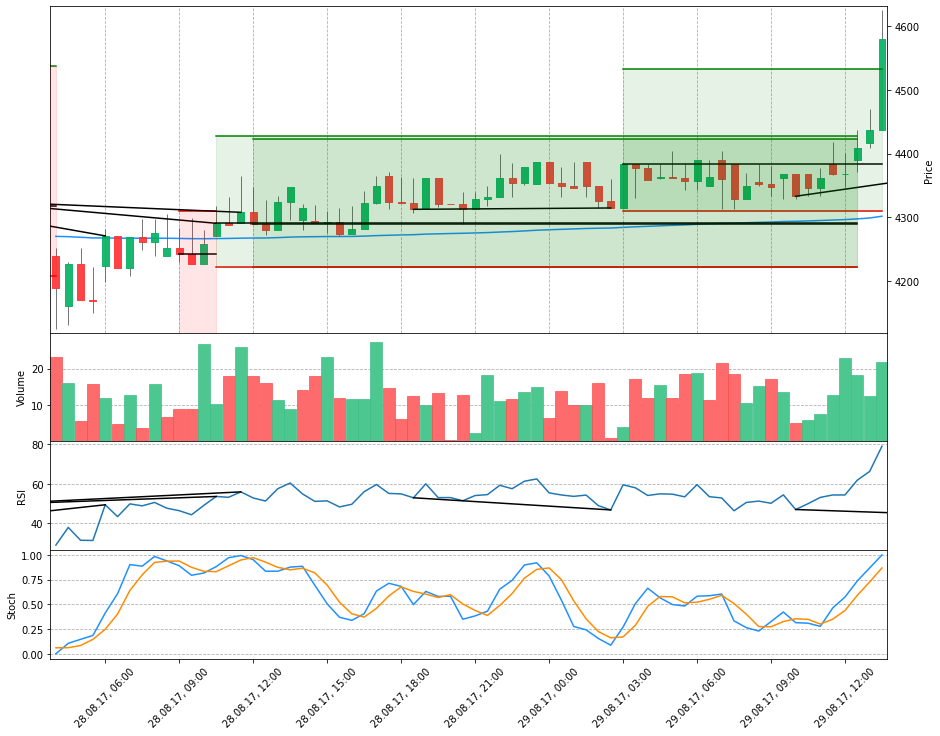

In [46]:
results.plot(pd.Timestamp('2017-08-28 04:00:00'), pd.Timestamp('2017-08-29 13:30:00'))#pd.Timestamp('2017-09-01 13:00:00'))